# Molecular Docking


## Dependencies


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

## Docking Class


In [28]:
class DockingClass:
    def __init__(self, receptor_file, ligand_file):
        self.receptor_file = receptor_file
        self.ligand_file = ligand_file
        self.conformers = None
        self.energies = None
        self.rmsd_matrix = None

    def setup(self) -> bool:
        """Load molecules."""
        try:
            self.receptor = Chem.MolFromPDBFile(self.receptor_file)
            if self.receptor is None:
                print("Failed to load receptor molecule")
                return False
            print(f"Receptor loaded successfully: {self.receptor.GetNumAtoms()} atoms")

            supplier = Chem.SDMolSupplier(self.ligand_file)
            self.ligand = next(supplier)
            if self.ligand is None:
                print("Failed to load ligand molecule")
                return False
            print(f"Ligand loaded successfully: {self.ligand.GetNumAtoms()} atoms")
            return True

        except Exception as e:
            print(f"Error in setup: {e}")
            return False

    def generate_conformers(self, n_conformers=10):
        """Generate and analyze ligand conformers."""
        print(f"\nGenerating {n_conformers} conformers...")
        try:
            mol = Chem.AddHs(self.ligand)

            # Generate conformers
            params = AllChem.ETKDGv3()
            params.randomSeed = 42
            params.numThreads = 0  # Use all available CPUs

            AllChem.EmbedMultipleConfs(mol, numConfs=n_conformers, params=params)

            # Optimize all conformers
            self.energies = []
            self.rmsd_matrix = np.zeros((n_conformers, n_conformers))

            print("\nOptimizing conformers and calculating properties...")
            for i in range(mol.GetNumConformers()):
                # MMFF optimization
                mp = AllChem.MMFFGetMoleculeProperties(mol)
                ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=i)
                ff.Minimize()
                energy = ff.CalcEnergy()
                self.energies.append(energy)

                # Calculate RMSD matrix
                for j in range(i + 1, mol.GetNumConformers()):
                    rmsd = AllChem.GetConformerRMS(mol, i, j)
                    self.rmsd_matrix[i, j] = rmsd
                    self.rmsd_matrix[j, i] = rmsd

            self.conformers = mol
            return self.energies, self.rmsd_matrix

        except Exception as e:
            print(f"Error generating conformers: {e}")
            return None, None

## Analysis


In [ ]:
def analyze_ligand_properties(ligand):
    """Analyze and print ligand molecular properties."""
    print("\nLigand Properties:")
    props = {
        "Molecular Weight": Chem.Descriptors.ExactMolWt(ligand),
        "Rotatable Bonds": Chem.rdMolDescriptors.CalcNumRotatableBonds(ligand),
        "H-Bond Donors": Chem.rdMolDescriptors.CalcNumHBD(ligand),
        "H-Bond Acceptors": Chem.rdMolDescriptors.CalcNumHBA(ligand),
        "Topological Polar Surface Area": Chem.Descriptors.TPSA(ligand),
    }

    for name, value in props.items():
        print(f"{name}: {value:.2f}")

    return props


def analyze_conformer_energies(energies):
    """Analyze energy distribution of conformers."""
    stats = {
        "Lowest Energy": min(energies),
        "Highest Energy": max(energies),
        "Mean Energy": np.mean(energies),
        "Energy Std Dev": np.std(energies),
        "Energy Range": max(energies) - min(energies),
    }

    print("\nEnergy Statistics (kcal/mol):")
    for name, value in stats.items():
        print(f"{name}: {value:.2f}")

    return stats


def cluster_conformers(rmsd_matrix, energies, rmsd_cutoff=2.0):
    """Cluster conformers based on RMSD values."""
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=rmsd_cutoff,
        metric="precomputed",
        linkage="complete",
    ).fit(rmsd_matrix)

    clusters = clustering.labels_
    n_clusters = len(set(clusters))

    print(f"\nConformer Clustering (RMSD cutoff = {rmsd_cutoff} Å):")
    print(f"Number of clusters: {n_clusters}")

    cluster_info = []
    for i in range(n_clusters):
        cluster_members = np.where(clusters == i)[0]
        cluster_energies = [energies[j] for j in cluster_members]
        info = {
            "cluster_id": i,
            "n_members": len(cluster_members),
            "avg_energy": np.mean(cluster_energies),
            "best_energy": min(cluster_energies),
            "members": cluster_members,
        }
        cluster_info.append(info)

        print(f"\nCluster {i+1}:")
        print(f"  Members: {info['n_members']}")
        print(f"  Average Energy: {info['avg_energy']:.2f} kcal/mol")
        print(f"  Best Energy: {info['best_energy']:.2f} kcal/mol")

    return cluster_info

## Plots


In [49]:
def plot_analysis(energies, rmsd_matrix):
    """
    Creates a comprehensive visualization of molecular docking results with improved styling and readability.
    
    Args:
        energies (list): List of energy values for each conformer
        rmsd_matrix (numpy.ndarray): Matrix of RMSD values between conformers
    """
    # Set up the overall style for better visualization
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    
    # Create figure and subplots with appropriate size
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Distribution of Conformer Energies using KDE
    sns.kdeplot(
        data=energies,
        ax=axes[0, 0],
        fill=True,
        color=sns.color_palette("deep")[0],
        linewidth=2
    )
    axes[0, 0].set_xlabel("Energy (kcal/mol)")
    axes[0, 0].set_ylabel("Density")
    axes[0, 0].set_title("Distribution of Conformer Energies")
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: RMSD Matrix Heatmap
    sns.heatmap(
        rmsd_matrix,
        ax=axes[0, 1],
        cmap='viridis',
        square=True,
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'RMSD (Å)'}
    )
    axes[0, 1].set_title("RMSD Matrix")
    axes[0, 1].set_xlabel("Conformer ID")
    axes[0, 1].set_ylabel("Conformer ID")
    
    # Plot 3: Energy vs Conformer ID
    sns.lineplot(
        x=range(1, len(energies) + 1),
        y=energies,
        ax=axes[1, 0],
        marker='o',
        markersize=8,
        color=sns.color_palette("deep")[2],
        linewidth=2
    )
    axes[1, 0].set_xlabel("Conformer ID")
    axes[1, 0].set_ylabel("Energy (kcal/mol)")
    axes[1, 0].set_title("Energy vs Conformer ID")
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Distribution of RMSD Values
    # Extract upper triangle RMSD values (excluding diagonal)
    rmsd_values = rmsd_matrix[np.triu_indices_from(rmsd_matrix, k=1)]
    sns.kdeplot(
        data=rmsd_values,
        ax=axes[1, 1],
        fill=True,
        color=sns.color_palette("deep")[3],
        linewidth=2
    )
    axes[1, 1].set_xlabel("RMSD (Å)")
    axes[1, 1].set_ylabel("Density")
    axes[1, 1].set_title("Distribution of RMSD Values")
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add main title to the figure
    fig.suptitle(
        'Molecular Docking Analysis Results',
        fontsize=14,
        y=1.02,
        fontweight='bold'
    )
    
    # Adjust layout and spacing
    plt.tight_layout()
    
    # Apply consistent styling to all subplots
    for ax in axes.flat:
        # Enhance tick label visibility
        ax.tick_params(labelsize=10)
        # Add subtle spines
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
        # Set title pad to prevent overlap
        ax.set_title(ax.get_title(), pad=15, fontsize=12)
    
    plt.show()
    
    return fig, axes

## Results


Receptor loaded successfully: 3180 atoms
Ligand loaded successfully: 20 atoms

Generating conformers...

Generating 10 conformers...

Optimizing conformers and calculating properties...

Analyzing ligand properties...

Ligand Properties:
Molecular Weight: 270.05
Rotatable Bonds: 1.00
H-Bond Donors: 3.00
H-Bond Acceptors: 5.00
Topological Polar Surface Area: 90.90

Analyzing conformer energies...

Energy Statistics (kcal/mol):
Lowest Energy: 34.64
Highest Energy: 44.75
Mean Energy: 36.66
Energy Std Dev: 4.04
Energy Range: 10.10

Clustering conformers...

Conformer Clustering (RMSD cutoff = 2.0 Å):
Number of clusters: 1

Cluster 1:
  Members: 10
  Average Energy: 36.66 kcal/mol
  Best Energy: 34.64 kcal/mol


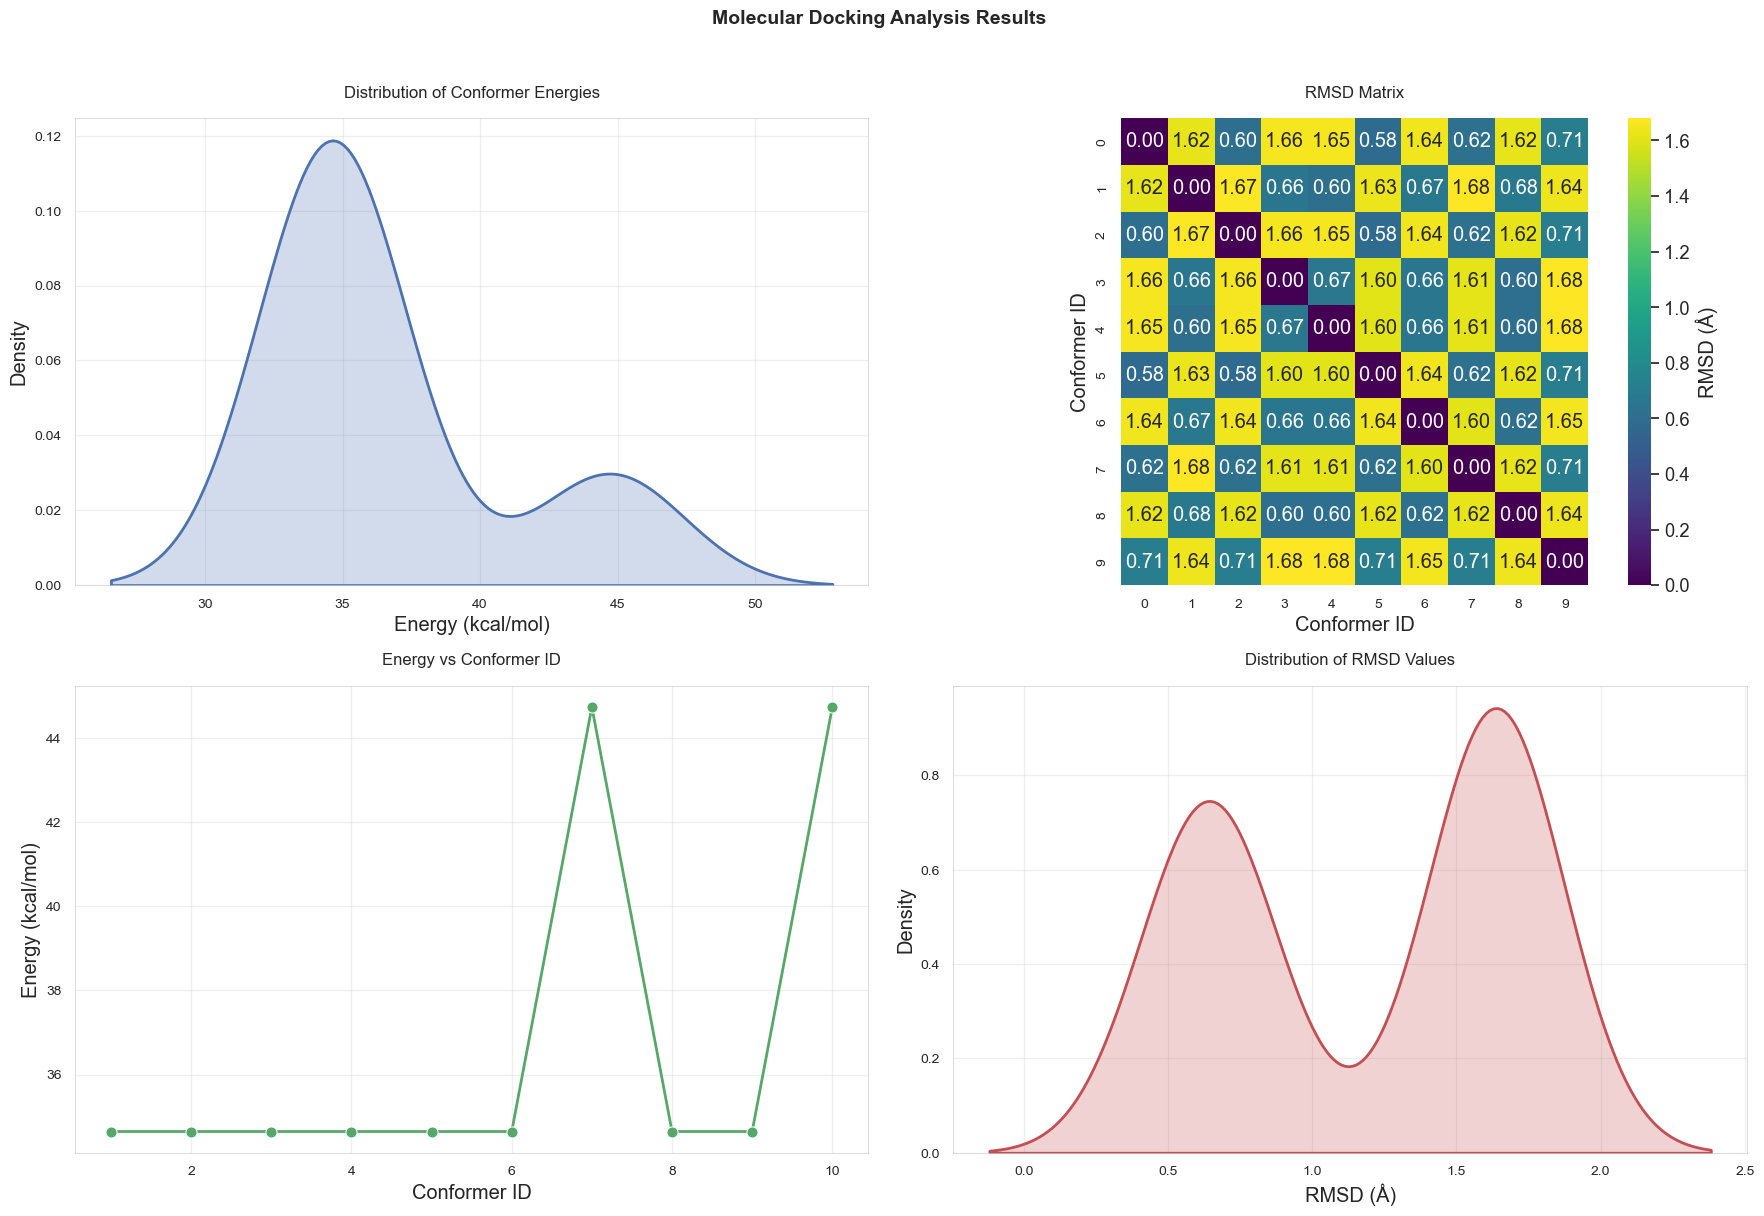

In [50]:
docking = DockingClass(
    receptor_file="../data/Receptors/BACE1-2WJO.pdb",
    ligand_file="../data/Ligands/Baicalein-5281605.sdf",
)

if docking.setup():
    print("\nGenerating conformers...")
    energies, rmsd_matrix = docking.generate_conformers(n_conformers=10)

    if energies is not None and rmsd_matrix is not None:
        # Analyze ligand properties
        print("\nAnalyzing ligand properties...")
        props = analyze_ligand_properties(docking.ligand)

        # Analyze conformer energies
        print("\nAnalyzing conformer energies...")
        energy_stats = analyze_conformer_energies(energies)

        # Cluster conformers
        print("\nClustering conformers...")
        clusters = cluster_conformers(rmsd_matrix, energies)

        # Create visualization
        plot_analysis(energies, rmsd_matrix)